In [10]:
import re
import pandas as pd

# Charger le fichier texte
with open("resultats_tests_minimax_vs_minimax.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Stockage des résultats
results = []

i = 0
while i < len(lines):
    line = lines[i].strip()
    if line.startswith("Partie"):
        partie = int(re.search(r"Partie (\d+)", line).group(1))

        i += 1
        line1 = lines[i].strip()
        match1 = re.search(r"IA 1 \(profondeur=(\d+)\) vs IA 2 \(profondeur=(\d+)\) : (IA \d+) vainqueur", line1)
        prof1, prof2, vainqueur = match1.groups()

        i += 1
        line2 = lines[i].strip()
        match2 = re.search(r"Nœuds créés - IA1: ([\d]+) \| IA2: ([\d]+)", line2)
        noeuds1, noeuds2 = match2.groups()

        i += 1
        line3 = lines[i].strip()
        match3 = re.search(r"Temps moyen/coup - IA1: ([\d.]+) ms \| IA2: ([\d.]+) ms", line3)
        temps1, temps2 = match3.groups()

        results.append({
            "Partie": partie,
            "IA1_Profondeur": int(prof1),
            "IA2_Profondeur": int(prof2),
            "Vainqueur": vainqueur,
            "Noeuds_IA1": int(noeuds1),
            "Noeuds_IA2": int(noeuds2),
            "Temps_IA1_ms": float(temps1),
            "Temps_IA2_ms": float(temps2),
        })
    i += 1

# Convertir en DataFrame
df = pd.DataFrame(results)

# Affichage (ou export)
print(df)
# df.to_csv("resultats_ab_vs_ab.csv", index=False)


    Partie  IA1_Profondeur  IA2_Profondeur Vainqueur  Noeuds_IA1  Noeuds_IA2  \
0        1               1               1      IA 1           8           8   
1        2               1               2      IA 2           5          20   
2        3               1               3      IA 2           8         400   
3        4               1               4      IA 2           8        2799   
4        5               1               5      IA 2           8       14128   
5        6               1               6      IA 1           4        1008   
6        8               2               2      IA 1           3           3   
7        9               2               3      IA 1          20          73   
8       10               2               4      IA 1           3           4   
9       11               2               5      IA 1          57       18742   
10      12               2               6      IA 1           7          62   
11      15               3              

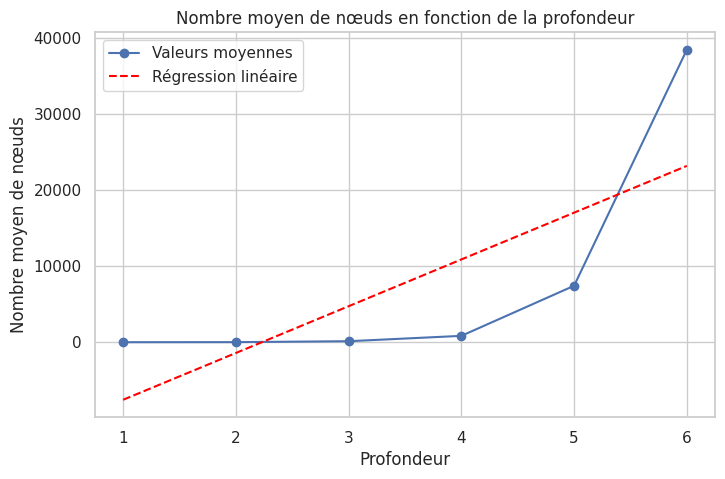

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Regrouper les nœuds par profondeur ---
noeuds_profondeur = {}

for _, row in df.iterrows():
    for ia in [1, 2]:
        prof = row[f"IA{ia}_Profondeur"]
        noeuds = row[f"Noeuds_IA{ia}"]
        if prof not in noeuds_profondeur:
            noeuds_profondeur[prof] = []
        noeuds_profondeur[prof].append(noeuds)

# --- Calcul des moyennes ---
moyenne_noeuds = {
    prof: sum(liste) / len(liste) for prof, liste in noeuds_profondeur.items()
}

# --- Données pour la régression ---
X = np.array(sorted(moyenne_noeuds.keys())).reshape(-1, 1)  # Profondeurs
y = np.array([moyenne_noeuds[k] for k in sorted(moyenne_noeuds.keys())])  # Moyennes

# --- Régression linéaire ---
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

# --- Tracé du graphique avec la régression ---
plt.figure(figsize=(8, 5))
plt.plot(X, y, marker='o', label='Valeurs moyennes')
plt.plot(X, y_pred, color='red', linestyle='--', label='Régression linéaire')
plt.xlabel("Profondeur")
plt.ylabel("Nombre moyen de nœuds")
plt.title("Nombre moyen de nœuds en fonction de la profondeur")
plt.legend()
plt.grid(True)
plt.show()


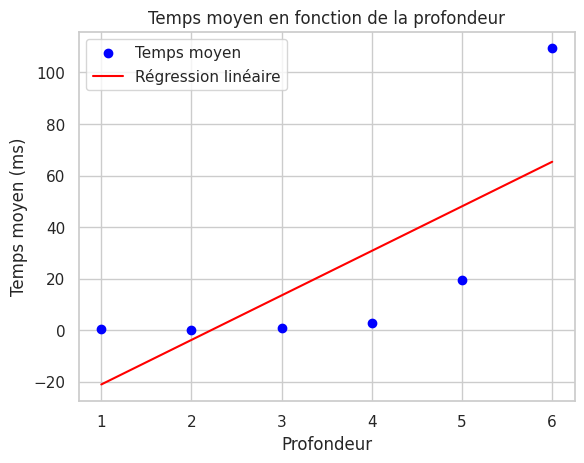

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Préparation des données : concaténation IA1 et IA2
df_ia1 = df[['IA1_Profondeur', 'Temps_IA1_ms']].rename(columns={'IA1_Profondeur': 'Profondeur', 'Temps_IA1_ms': 'Temps_ms'})
df_ia2 = df[['IA2_Profondeur', 'Temps_IA2_ms']].rename(columns={'IA2_Profondeur': 'Profondeur', 'Temps_IA2_ms': 'Temps_ms'})
df_long = pd.concat([df_ia1, df_ia2], ignore_index=True)

# Calcul du temps moyen par profondeur
temps_moyen_par_profondeur = df_long.groupby('Profondeur')['Temps_ms'].mean().reset_index()

# Données pour la régression
X = temps_moyen_par_profondeur['Profondeur'].values.reshape(-1, 1)
y = temps_moyen_par_profondeur['Temps_ms'].values

# Modèle de régression linéaire
model = LinearRegression()
model.fit(X, y)

# Prédiction pour la droite de régression
X_range = np.arange(X.min(), X.max() + 1).reshape(-1, 1)
y_pred = model.predict(X_range)

# Tracé
plt.scatter(temps_moyen_par_profondeur['Profondeur'], temps_moyen_par_profondeur['Temps_ms'], color='blue', label='Temps moyen')
plt.plot(X_range, y_pred, color='red', label='Régression linéaire')
plt.xlabel('Profondeur')
plt.ylabel('Temps moyen (ms)')
plt.title('Temps moyen en fonction de la profondeur')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd

# Fusionner les infos des deux IA dans un seul tableau long (melt-like)
all_data = []

for _, row in df.iterrows():
    for ia in [1, 2]:
        prof = row[f"IA{ia}_Profondeur"]
        noeuds = row[f"Noeuds_IA{ia}"]
        temps = row[f"Temps_IA{ia}_ms"]
        gagnant = (row["Vainqueur"] == f"IA {ia}")
        all_data.append({
            "IA": f"IA{ia}",
            "Profondeur": prof,
            "Noeuds": noeuds,
            "Temps_ms": temps,
            "Victoire": int(gagnant)
        })

df_long = pd.DataFrame(all_data)

# Regrouper par profondeur
stats = df_long.groupby("Profondeur").agg({
    "Noeuds": "mean",
    "Temps_ms": "mean",
    "Victoire": ["sum", "count"]
}).reset_index()

# Renommer les colonnes
stats.columns = ["Profondeur", "Noeuds_moyens", "Temps_moyen_ms", "Victoires", "Total"]

# Calcul du % de victoire
stats["% Victoires"] = 100 * stats["Victoires"] / stats["Total"]

# Déterminer le "vainqueur dominant" par profondeur si >50% des parties gagnées
stats["Vainqueur_dominant"] = stats["% Victoires"].apply(lambda x: "Souvent gagnant" if x > 50 else "Souvent perdant")

# Afficher le tableau
print(stats[["Profondeur", "Noeuds_moyens", "Temps_moyen_ms", "% Victoires", "Vainqueur_dominant"]])


   Profondeur  Noeuds_moyens  Temps_moyen_ms  % Victoires Vainqueur_dominant
0           1       7.000000        0.370571    28.571429    Souvent perdant
1           2      16.142857        0.145714    85.714286    Souvent gagnant
2           3     140.000000        0.681857    42.857143    Souvent perdant
3           4     843.714286        2.895000    57.142857    Souvent gagnant
4           5    7427.285714       19.446000    57.142857    Souvent gagnant
5           6   38441.000000      109.328286    28.571429    Souvent perdant


   itérations     C  simulations  profondeur noeuds_niveau  branche_max  \
0         100   1.0            1           2     [1, 7, 7]            7   
1         100   1.0            5           1        [1, 7]            7   
2         100   1.0           10           2    [1, 7, 10]            7   
3         100  10.0            1           1        [1, 7]            7   
4         100  10.0            5           1        [1, 7]            7   

   total_noeuds  
0            15  
1             8  
2            18  
3             8  
4             8  


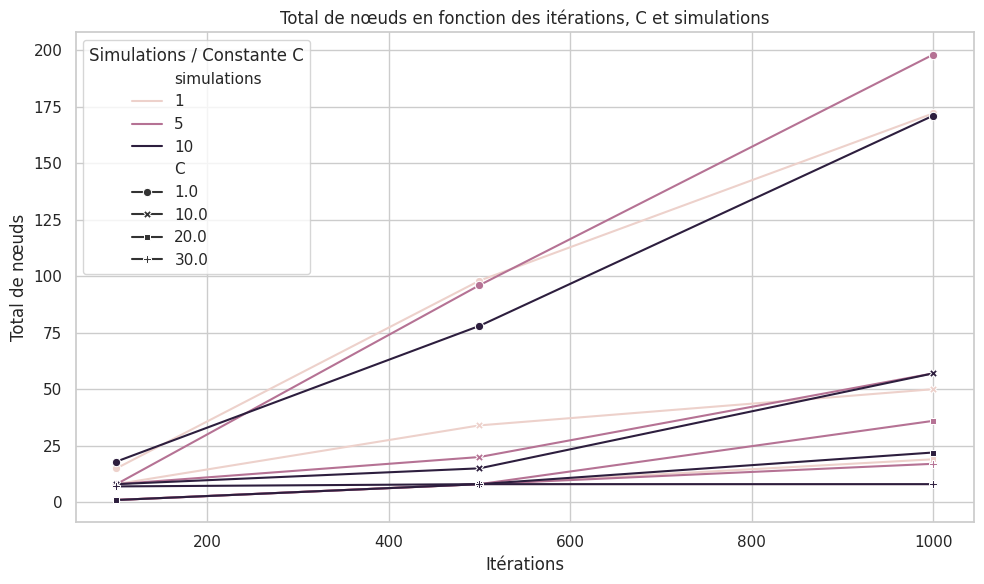

<ipython-input-1-512164192>:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="C", y="profondeur", ci=None, estimator="mean")


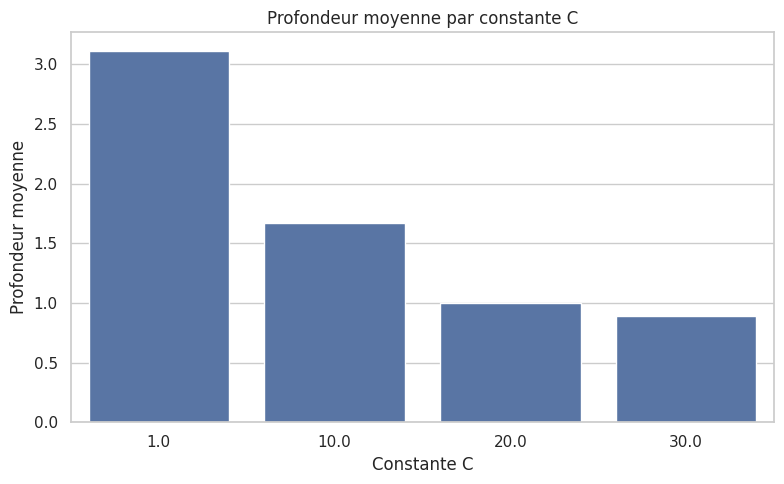

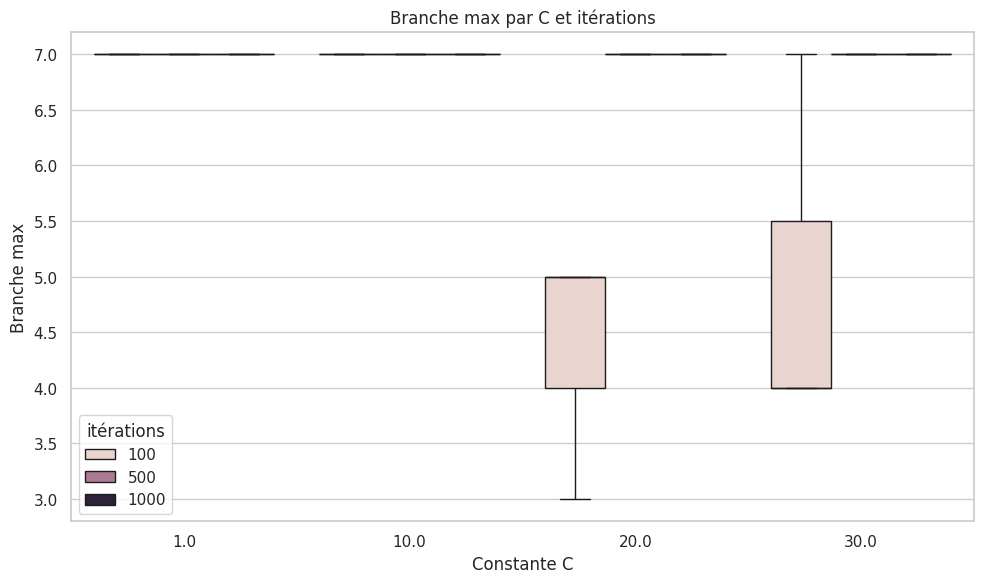

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier
with open("analyse_arbres_mcts.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Extraction des données
data = []

pattern = re.compile(
    r"itérations=(\d+), C=([\d.]+), simulations=(\d+) \| Profondeur: (\d+) \| Nœuds/niveau: \[([^\]]+)\] \| Branche max: (\d+)"
)

for line in lines:
    match = pattern.search(line)
    if match:
        it = int(match.group(1))
        c = float(match.group(2))
        sim = int(match.group(3))
        prof = int(match.group(4))
        noeuds_niveau = list(map(int, match.group(5).split(", ")))
        branche_max = int(match.group(6))
        total_noeuds = sum(noeuds_niveau)

        data.append({
            "itérations": it,
            "C": c,
            "simulations": sim,
            "profondeur": prof,
            "noeuds_niveau": noeuds_niveau,
            "branche_max": branche_max,
            "total_noeuds": total_noeuds
        })

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage pour vérif rapide
print(df.head())

# --- 🔢 GRAPHIQUES ---

sns.set(style="whitegrid")

# 📈 1. Total de nœuds en fonction des itérations et simulations
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="itérations", y="total_noeuds", hue="simulations", style="C", markers=True, dashes=False)
plt.title("Total de nœuds en fonction des itérations, C et simulations")
plt.xlabel("Itérations")
plt.ylabel("Total de nœuds")
plt.legend(title="Simulations / Constante C")
plt.tight_layout()
plt.show()

# 📊 2. Profondeur moyenne selon C
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="C", y="profondeur", ci=None, estimator="mean")
plt.title("Profondeur moyenne par constante C")
plt.xlabel("Constante C")
plt.ylabel("Profondeur moyenne")
plt.tight_layout()
plt.show()

# 📈 3. Branche max en fonction de C et itérations
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="C", y="branche_max", hue="itérations")
plt.title("Branche max par C et itérations")
plt.xlabel("Constante C")
plt.ylabel("Branche max")
plt.tight_layout()
plt.show()
